<a href="https://colab.research.google.com/github/ameyas1/Sentiment_Analysis/blob/master/bert_tfhub_with_only_Tfdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Download Dataset From Kaggle**

In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [2]:
!pip install -q tf-nightly
!pip install -q tf-models-nightly

     |████████████████████████████████| 324.5MB 56kB/s 
     |████████████████████████████████| 6.8MB 56.4MB/s 
     |████████████████████████████████| 460kB 52.6MB/s 
     |████████████████████████████████| 880kB 8.6MB/s 
     |████████████████████████████████| 1.1MB 30.2MB/s 
     |████████████████████████████████| 36.4MB 83kB/s 
     |████████████████████████████████| 174kB 55.4MB/s 
     |████████████████████████████████| 102kB 14.6MB/s 
     |████████████████████████████████| 358kB 54.2MB/s 
     |████████████████████████████████| 296kB 51.5MB/s 


In [3]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 35% 9.00M/25.7M [00:00<00:01, 17.1MB/s]
100% 25.7M/25.7M [00:00<00:00, 47.0MB/s]


In [4]:
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization

In [5]:
import official.nlp.bert.tokenization

In [6]:
!unzip /content/imdb-dataset-of-50k-movie-reviews.zip

Archive:  /content/imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [7]:
# !pip install bert-for-tf2

In [8]:
import numpy as np 
import pandas as pd
# import bert
from tensorflow.keras.models import Model       # Keras is the new high level API for TensorFlow
import math
import tensorflow as tf
import tensorflow_hub as hub


In [9]:
FullTokenizer = bert.tokenization.FullTokenizer

In [10]:
# max_seq_length = 1024  # Your choice here.
# input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
#                                        name="input_word_ids")
# input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
#                                    name="input_mask")
# segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
#                                     name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/2",
                            trainable=True)
# pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [11]:
# model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, sequence_output])

In [12]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [13]:
help(tokenizer)

Help on FullTokenizer in module official.nlp.bert.tokenization object:

class FullTokenizer(builtins.object)
 |  Runs end-to-end tokenziation.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, vocab_file, do_lower_case=True, split_on_punc=True)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  convert_ids_to_tokens(self, ids)
 |  
 |  convert_tokens_to_ids(self, tokens)
 |  
 |  tokenize(self, text)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



**Preprocess**

In [14]:
df=pd.read_csv("/content/imdb-dataset-of-50k-movie-reviews.zip")

In [15]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [16]:
df.shape

(50000, 2)

In [17]:
df.dropna(inplace=True)

In [18]:
df.shape

(50000, 2)

In [19]:
# df=df[[0,5]]
# df.columns = ['sentiment','text']

In [20]:
import re

def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext


def process_text(text):
    text = text.replace('#', 'hashtag ')
    text = re.sub(r"https?://\S+", '', text)
    text = re.sub(r"^@\S+|\s@\S+",'', text)
    text = cleanhtml(text)

    
    return text.strip().rstrip()

In [21]:
def conv_1_0(sentiment):
  if sentiment == 'positive':
    sentiment = 1
  else:
    sentiment = 0
  return sentiment

In [22]:
df.sentiment = df.sentiment.apply(conv_1_0)

In [23]:
df.review = df.review.apply(process_text)

In [24]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [25]:
df.dropna(inplace=True)

In [26]:
df.isnull().sum(axis = 0)

review       0
sentiment    0
dtype: int64

In [27]:
sentiments = df.sentiment.values
sentences = df.review.values

In [28]:
sentiments[:10]

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1])

In [29]:
df.sentiment.unique()

array([1, 0])

In [30]:
set(sentiments)

{0, 1}

In [31]:
sentiments[-1],sentences[-1]

(0,
 "No one expects the Star Trek movies to be high art, but the fans do expect a movie that is as good as some of the best episodes. Unfortunately, this movie had a muddled, implausible plot that just left me cringing - this is by far the worst of the nine (so far) movies. Even the chance to watch the well known characters interact in another movie can't save this movie - including the goofy scenes with Kirk, Spock and McCoy at Yosemite.I would say this movie is not worth a rental, and hardly worth watching, however for the True Fan who needs to see all the movies, renting this movie is about the only way you'll see it - even the cable channels avoid this movie.")

In [32]:
sentiments[100],sentences[100]

(1,
 "This short film that inspired the soon-to-be full length feature - Spatula Madness - is a hilarious piece that contends against similar cartoons yielding multiple writers. The short film stars Edward the Spatula who after being fired from his job, joins in the fight against the evil spoons. This premise allows for some funny content near the beginning, but is barely present for the remainder of the feature. This film's 15-minute running time is absorbed by some odd-ball comedy and a small musical number. Unfortunately not much else lies below it. The plot that is set up doesn't really have time to show. But it's surely follows it plot better than many high-budget Hollywood films. This film is worth watching at least a few times. Take it for what it is, and don't expect a deep story.")

In [33]:
def encode_sentence_and_create_mask_segment(s):
  tokens = tokenizer.tokenize(s.numpy())

  if len(tokens) >= 511:
    tokens = tokens[:510]

  tokens = ["[CLS]"] + tokens + ["[SEP]"]

  input_word_ids = [tokenizer.convert_tokens_to_ids(tokens)]

  input_mask = np.ones_like(input_word_ids)
    
  input_segment = np.zeros_like(input_word_ids)

  input_word_ids = tf.keras.preprocessing.sequence.pad_sequences(input_word_ids, maxlen=512, dtype='int32', padding='post',value=0)

  input_mask = tf.keras.preprocessing.sequence.pad_sequences(input_mask, maxlen=512, dtype='int32', padding='post',value=0)

  input_segment = tf.keras.preprocessing.sequence.pad_sequences(input_segment, maxlen=512, dtype='int32', padding='post',value=0)

  return np.squeeze(input_word_ids), np.squeeze(input_mask), np.squeeze(input_segment)


In [34]:
def bert_encode(sentences, sentiments):

    input_word_ids, input_mask, input_segment = tf.py_function(encode_sentence_and_create_mask_segment, [sentences], [tf.int32, tf.int32, tf.int32])
        
    print('input ids done')
    
    print('input masks done')
    
    print('input segments done')
    
    inputs = {
      'input_word_ids': input_word_ids,
      'input_mask': input_mask,
      'segment_ids': input_segment}

    return inputs, sentiments

In [35]:
BUFFER_SIZE = len(df)
BATCH_SIZE =8

In [36]:

dataset = tf.data.Dataset.from_tensor_slices((tf.constant(sentences), tf.constant(sentiments))).map(bert_encode, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)



input ids done
input masks done
input segments done


In [37]:
%%time
for x,y in dataset.take(1):
  print(x)
  print(y)

{'input_word_ids': <tf.Tensor: shape=(8, 512), dtype=int32, numpy=
array([[  101,  1188,  1273, ...,     0,     0,     0],
       [  101,  1790,   112, ...,     0,     0,     0],
       [  101,  1332,  1128, ...,     0,     0,     0],
       ...,
       [  101,   146,  1156, ...,     0,     0,     0],
       [  101,   146,  2426, ...,     0,     0,     0],
       [  101, 15580,   117, ...,     0,     0,     0]], dtype=int32)>, 'input_mask': <tf.Tensor: shape=(8, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'segment_ids': <tf.Tensor: shape=(8, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>}
tf.T

In [38]:
example_input_batch, example_target_batch = next(iter(dataset))


In [39]:
# import pickle

# with open('inp.p', 'wb') as fp:
#     pickle.dump(inputs, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
# with open('sent.p', 'wb') as fp1:
#     pickle.dump(senti, fp1, protocol=pickle.HIGHEST_PROTOCOL)

In [41]:
# !mv /content/inp.p '/content/drive/My Drive/cp'
# !mv /content/sent.p '/content/drive/My Drive/cp'

In [42]:
# import pickle

# with open('/content/drive/My Drive/cp/inp.p', 'rb') as p:
#     inputs = pickle.load(p)

# with open('/content/drive/My Drive/cp/sent.p', 'rb') as p1:
#     sentiment = pickle.load(p1)

In [43]:
# sentiments = sentiment['sentiments']

In [44]:
def test(tokenizer, inputs, sentiments, ind):
  print('ids')
  print(inputs['input_word_ids'][ind])
  print('mask')
  print(inputs['input_mask'][ind])
  print('segment')
  print(inputs['segment_ids'][ind])
  print('words')
  for t in inputs['input_word_ids'][ind]:
    if t!=0:
      print(tokenizer.convert_ids_to_tokens([t.numpy()]))
  print('sentiment')
  print(sentiments[ind])



In [45]:
# test(tokenizer,inputs, sentiments, 60)
test(tokenizer,example_input_batch, example_target_batch,-1)

ids
tf.Tensor(
[  101  8636   170  5955  1603  2801  1104  9507  2199  4035  4568  1424
  1366  1164  1297  1107  5776   119  1636  2801  1132  9455 12821  7912
  1105  1296  2515   170  2741  1107  1134   170  1488  1596 11147  1110
  1767   119  1188  6653  1115  1103  1958  7801  3333  1120  1103  1269
  1159   119  1109  1273  3471  1114   170   171  4380  1183  5152  1134
 11323  1199  8061  1133  1103  1346  2801  1132  2385  1822  2501   119
  1109  1273  4607  1116  1177  6166  1114  1122   119  1960  3088 13554
  1107  2801  1115  2812  2194  7722  1104  3362  1229   170  2741  1107
   170  2704  3114  1366   170  6020  1193  5178  5351 13498  1111  2489
  3893   119  1109  1314  4899  1114  1117  1676  1132  1241 13870  1105
  2232   119  1799  1103  1672  4429  1104  1266  1297  1321  1282  1107
  5776   117  1103  6621  1132  1104   170  1704  2731 12826  1128  3333
  1106  1686   119 26294  1104  1603  2801  1132  6034  1112 18330  1112
   170  1363  8901  3078   118  2517

In [46]:
max_seq_length = 512  # Your choice here.
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/2",
                            trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [47]:
expand_pool = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,1))(pooled_output)
pool_lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(160,return_sequences=True))(expand_pool)
pool_lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(160))(pool_lstm1)
# model.add(tf.keras.layers.Dense(160, activation='relu'))

In [48]:
seq_lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(160,return_sequences=True))(sequence_output)
seq_lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(160))(seq_lstm1)

In [49]:
concat = tf.keras.layers.concatenate([seq_lstm2,pool_lstm2])

In [50]:
dense1 = tf.keras.layers.Dense(320, activation='relu')(concat)
do1 = tf.keras.layers.Dropout(0.2)(dense1)
dense2 = tf.keras.layers.Dense(160, activation='relu')(do1)
do2 = tf.keras.layers.Dropout(0.2)(dense2)
pred = tf.keras.layers.Dense(2, activation='softmax')(do2)

model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pred)

In [51]:
# last_layer = model.get_layer('keras_layer_1')
# print('keras layer output shape: ', last_layer.output_shape)

In [52]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 108310273   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

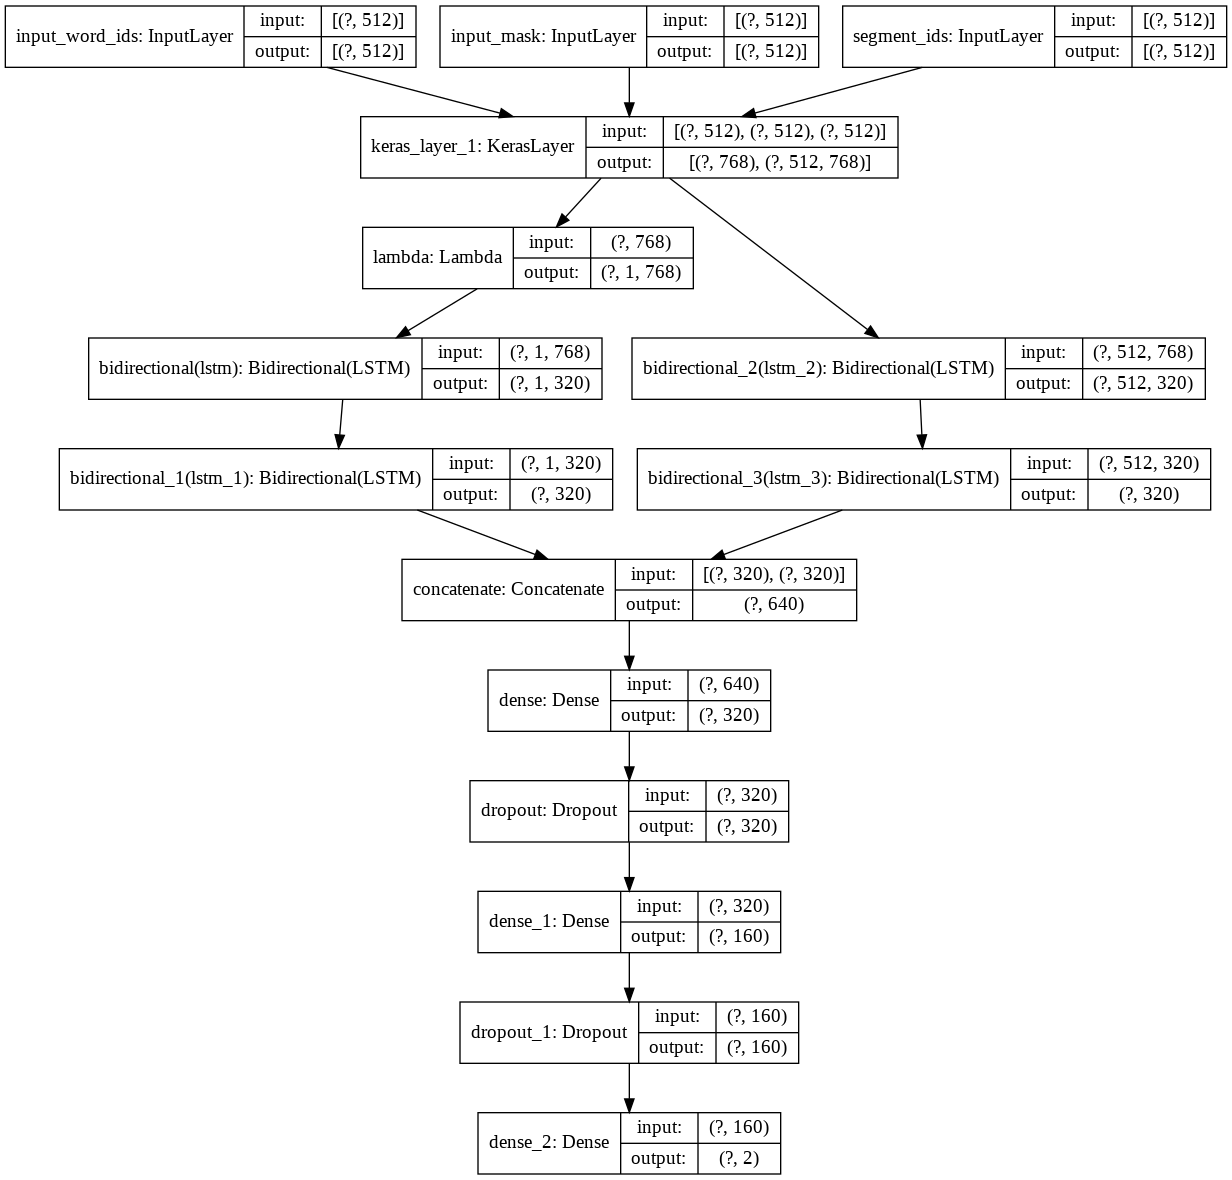

In [53]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [54]:
epochs = 1
# train_data_size = len(sentiments)
# steps_per_epoch = int(train_data_size / BATCH_SIZE)
# num_train_steps = steps_per_epoch * epochs
# warmup_steps = int(epochs * train_data_size * 0.1 / BATCH_SIZE)
# optimizer = nlp.optimization.create_optimizer(
#     2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [56]:
type(optimizer)

tensorflow.python.keras.optimizer_v2.adam.Adam

In [57]:
model.compile(optimizer = optimizer, 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [58]:
# from tensorflow.keras.callbacks import ModelCheckpoint
# filepath="cp/sentiment_model.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

# checkpoint = tf.keras.callbacks.experimental.BackupAndRestore(backup_dir='/content/cp')

# !mkdir cp


# callbacks_list = [checkpoint]

In [87]:
model.load_weights('/content/sentiments_bert.hdf5')

In [84]:
history = model.fit(dataset, epochs=epochs) #, callbacks=callbacks_list

6250/6250 [==============================] - 2724s 436ms/step - loss: 0.1722 - accuracy: 0.9353


In [85]:
!rm /content/sentiments_bert.hdf5

In [86]:
model.save_weights('sentiments_bert.hdf5')

In [92]:
!rm '/content/drive/My Drive/cp/sentiments_bert.hdf5'

In [93]:
!cp /content/sentiments_bert.hdf5 '/content/drive/My Drive/cp'

<Figure size 432x288 with 0 Axes>

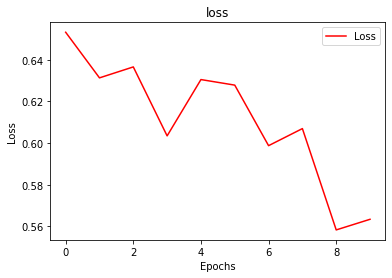

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']


epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training  loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
# plt.plot(epochs, v_loss, 'b')
plt.title('loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [79]:
model.load_weights('/content/drive/My Drive/cp/sentiments_bert.hdf5')

In [88]:
def predict_sentiment(text, tokenizer, max_len):
  
  processed_text = process_text(text)
  tokens = list(tokenizer.tokenize(processed_text))

  if len(tokens) >= 511:
    tokens = tokens[:510]
  tokens = ["[CLS]"] + tokens + ["[SEP]"]

  print(tokens)
  
  encoded = tokenizer.convert_tokens_to_ids(tokens)

  encoded = tf.expand_dims(encoded, axis=0)
  
  input_mask = tf.ones_like(encoded)
    
  input_segment = tf.zeros_like(encoded)

  input_word_ids = tf.keras.preprocessing.sequence.pad_sequences(
  encoded, maxlen=max_len, dtype='int32', padding='post',value=0)

  input_mask = tf.keras.preprocessing.sequence.pad_sequences(
  input_mask, maxlen=max_len, dtype='int32', padding='post',value=0)
    
    
  input_segment = tf.keras.preprocessing.sequence.pad_sequences(
  input_segment, maxlen=max_len, dtype='int32', padding='post',value=0)

  inputs = {'input_word_ids': input_word_ids, 'input_mask': input_mask, 'segment_ids': input_segment}

  score = model.predict(inputs)[0]

  return {"negative": float(score[0]), "postive": float(score[1])} 










In [89]:
predict_sentiment("He can surely cry. I loved the movie.", tokenizer, max_len=512)

['[CLS]', 'He', 'can', 'surely', 'cry', '.', 'I', 'loved', 'the', 'movie', '.', '[SEP]']


{'negative': 0.06703341007232666, 'postive': 0.9329666495323181}

In [90]:
predict_sentiment('Wow! The K-drama I just watched,\'Hotel Del Luna\',left me speechless. I  enjoyed it very much. It was sad too,Pleading face  Yeo Jin Goo can really cry, poor guy.', tokenizer, max_len=512)

['[CLS]', 'Wow', '!', 'The', 'K', '-', 'drama', 'I', 'just', 'watched', ',', "'", 'Hotel', 'Del', 'Luna', "'", ',', 'left', 'me', 'speech', '##less', '.', 'I', 'enjoyed', 'it', 'very', 'much', '.', 'It', 'was', 'sad', 'too', ',', 'P', '##leading', 'face', 'Ye', '##o', 'Jin', 'Go', '##o', 'can', 'really', 'cry', ',', 'poor', 'guy', '.', '[SEP]']


{'negative': 0.04257277771830559, 'postive': 0.9574272632598877}